In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import networkx as nx
from sklearn.metrics import mutual_info_score

def calculate_bic(data, graph):
    score = 0
    n = len(data)  # Number of data points
    
    for node in graph.nodes:
        parents = list(graph.predecessors(node))
        if parents:
            if len(parents) == 1:
                # Single parent: use it as a Series
                parent_series = data[parents[0]]
            else:
                # Multiple parents: concatenate their values into a single string column
                parent_series = data[parents].astype(str).agg('-'.join, axis=1)

            # Create the contingency table for the node and its parents
            contingency_table = pd.crosstab(parent_series, data[node], margins=True)

            # Calculate the log-likelihood
            log_likelihood = 0
            for parent_state, row in contingency_table.iterrows():
                if parent_state == 'All':
                    continue
                row_sum = row['All']
                for state, count in row.items():
                    if state != 'All' and row_sum > 0:
                        probability = count / row_sum
                        if probability > 0:
                            log_likelihood += count * np.log(probability)

        else:
            # No parents: use the marginal distribution of the node
            counts = data[node].value_counts()
            total = counts.sum()
            log_likelihood = sum(count * np.log(count / total) for count in counts if count > 0)
        
        # Calculate the number of free parameters
        num_params = (data[node].nunique() - 1) * np.prod([data[parent].nunique() for parent in parents])
        
        # Update the BIC score
        score += log_likelihood
        score -= num_params / 2 * np.log(n)

    return score


def tree_hill_climbing(data):
    # Start with a tree structure where the target variable has no parents
    best_graph = nx.DiGraph()
    best_graph.add_nodes_from(data.columns)
    best_score = float('-inf')
    
    # Initialize the tree with the target node (assumed to be the last column in the dataset)
    target_node = data.columns[-1]
    
    # Iteratively add the best parent to each node until the score no longer improves
    improved = True
    while improved:
        improved = False
        for node in set(data.columns) - {target_node}:
            # Try adding a new parent to 'node' that maximizes the BIC score
            potential_parents = set(data.columns) - {node} - set(best_graph.predecessors(node))
            for parent in potential_parents:
                # Create a copy of the current graph
                new_graph = best_graph.copy()
                new_graph.add_edge(parent, node)
                
                # Ensure the new graph is still a DAG
                if nx.is_directed_acyclic_graph(new_graph):
                    new_score = calculate_bic(data, new_graph)
                    if new_score > best_score:
                        best_graph = new_graph
                        best_score = new_score
                        improved = True
                        break  # Stop looking for more parents for this node
    
    return best_graph

# Load dataset
data = pd.read_csv('heart.csv')

# Identify continuous variables
continuous_vars = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Discretize each continuous variable
for var in continuous_vars:
    data[var + '_binned'] = pd.qcut(data[var], q=3, labels=False, duplicates='drop')

#Drop original continuous variables 
data = data.drop(columns=continuous_vars)

#Split the data into training and validation sets (85% - 15%)
train_data, validation_data = train_test_split(data, test_size=0.15, random_state=42)

#Initialize the Bayesian Network graph
bn_graph = nx.DiGraph()
for column in train_data.columns:
    bn_graph.add_node(column)

# Learn the structure
bn_structure = tree_hill_climbing(train_data)


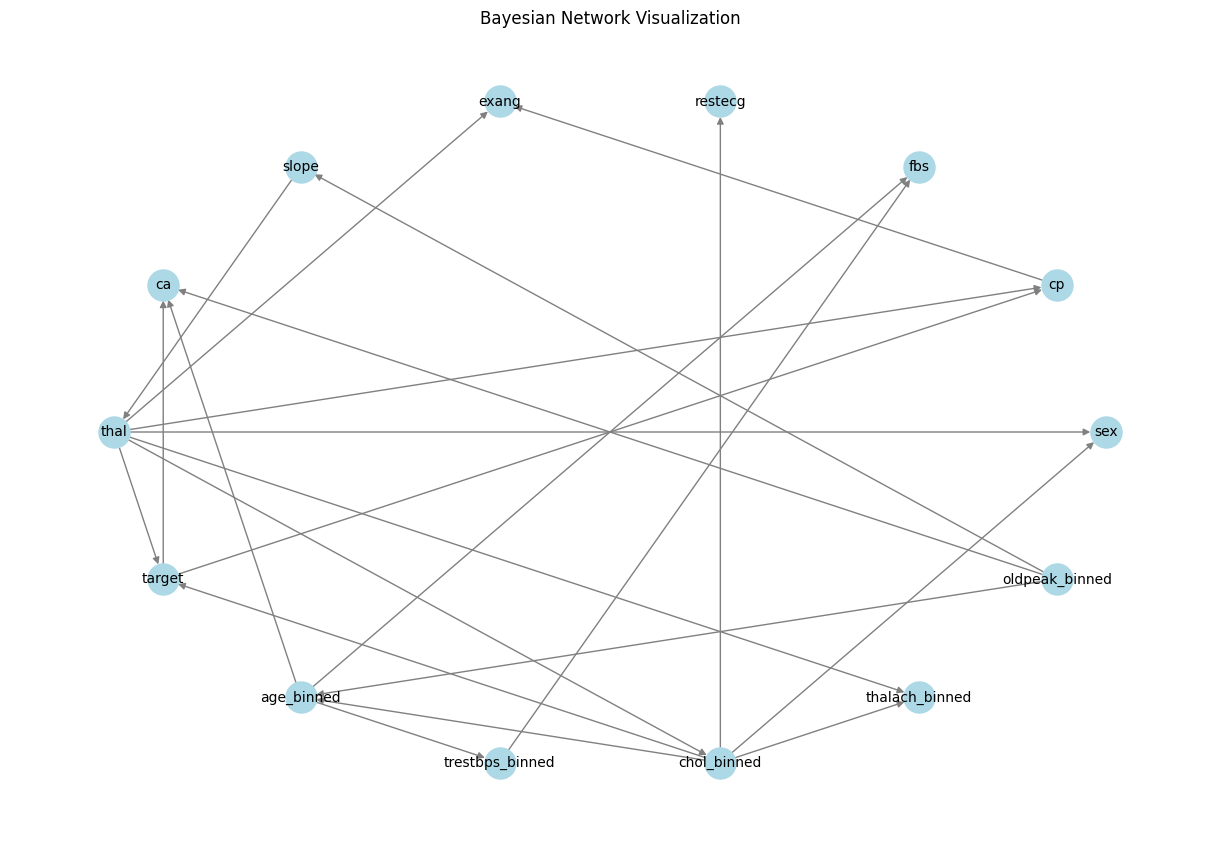

In [5]:
import matplotlib.pyplot as plt
# Use circular layout
pos = nx.circular_layout(bn_structure)

# Draw the network
plt.figure(figsize=(12, 8))
nx.draw(bn_structure, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, edge_color='gray')

# Show the plot
plt.title("Bayesian Network Visualization")
plt.show()


Index(['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'target',
       'age_binned', 'trestbps_binned', 'chol_binned', 'thalach_binned',
       'oldpeak_binned'],
      dtype='object')


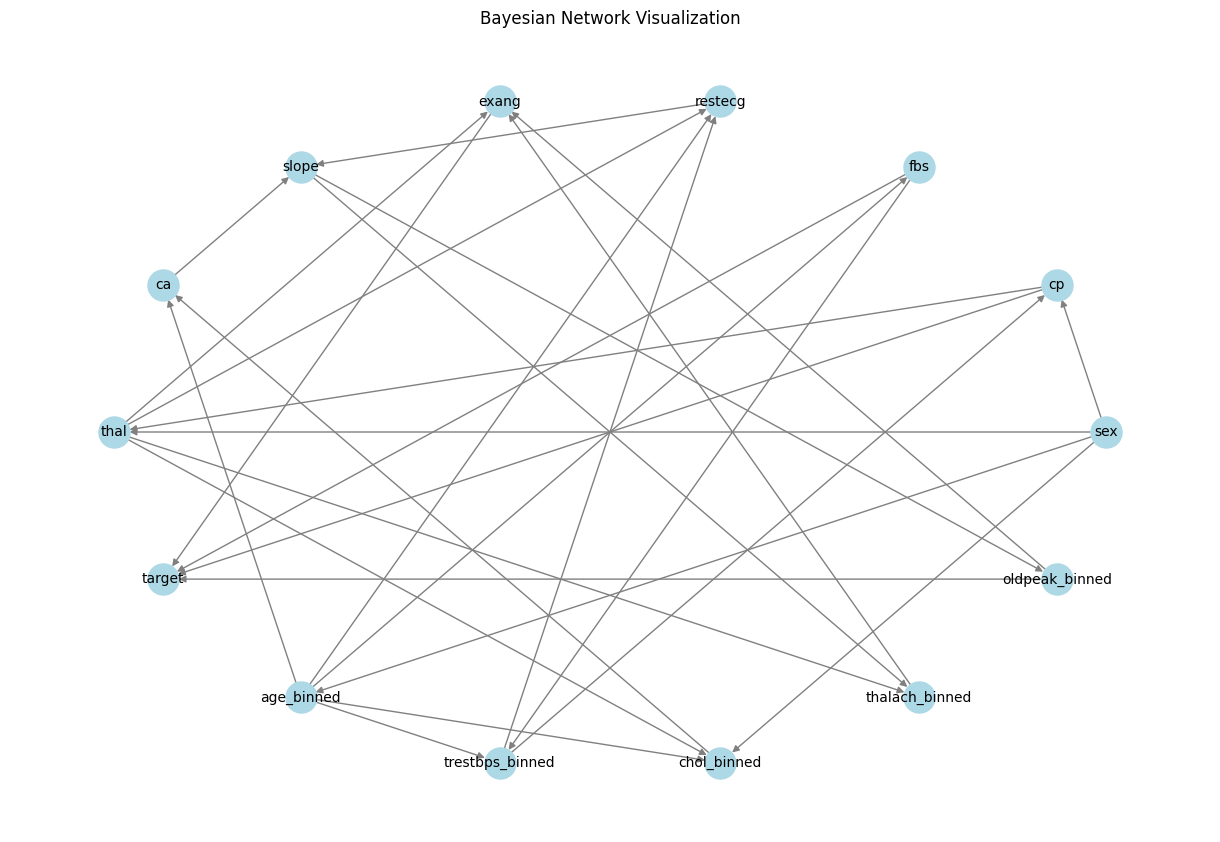

In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import networkx as nx
from sklearn.metrics import mutual_info_score
import matplotlib.pyplot as plt
def calculate_bic(data, graph):
    score = 0
    n = len(data)  # Number of data points
    
    for node in graph.nodes:
        parents = list(graph.predecessors(node))
        if parents:
            if len(parents) == 1:
                # Single parent: use it as a Series
                parent_series = data[parents[0]]
            else:
                # Multiple parents: concatenate their values into a single string column
                parent_series = data[parents].astype(str).agg('-'.join, axis=1)

            # Create the contingency table for the node and its parents
            contingency_table = pd.crosstab(parent_series, data[node], margins=True)

            # Calculate the log-likelihood
            log_likelihood = 0
            for parent_state, row in contingency_table.iterrows():
                if parent_state == 'All':
                    continue
                row_sum = row['All']
                for state, count in row.items():
                    if state != 'All' and row_sum > 0:
                        probability = count / row_sum
                        if probability > 0:
                            log_likelihood += count * np.log(probability)

        else:
            # No parents: use the marginal distribution of the node
            counts = data[node].value_counts()
            total = counts.sum()
            log_likelihood = sum(count * np.log(count / total) for count in counts if count > 0)
        
        # Calculate the number of free parameters
        num_params = (data[node].nunique() - 1) * np.prod([data[parent].nunique() for parent in parents])
        
        # Update the BIC score
        score += log_likelihood
        score -= num_params / 2 * np.log(n)

    return score

def create_expert_graph(columns):
    expert_graph = nx.DiGraph()

    # Define the edges based on the expert's knowledge, using the binned variable names
    expert_edges = [
        ("age_binned", "trestbps_binned"), ("age_binned", "restecg"), ("age_binned", "fbs"), ("age_binned", "chol_binned"),
        ("sex", "chol_binned"),
        ("chol_binned", "ca"),
        ("ca", "slope"),
        ("slope", "oldpeak_binned"),
        ("oldpeak_binned", "exang"), ("oldpeak_binned", "target"),
        ("exang", "target"),
        ("fbs", "target"),
        ("restecg", "slope"),
        ("thal", "exang"), ("thal", "thalach_binned"), ("thal", "restecg"),
        ("thalach_binned", "exang"),
        ("trestbps_binned", "restecg"), ("trestbps_binned", "cp"),
        ("cp", "target")
    ]

    # Add nodes and edges to the graph
    expert_graph.add_nodes_from(data.columns)
    expert_graph.add_edges_from(expert_edges)

    return expert_graph


def tree_hill_climbing(data, initial_graph):
    best_graph = initial_graph
    best_score = float('-inf')
    
    # Initialize the tree with the target node (assumed to be the last column in the dataset)
    target_node = data.columns[-1]
    
    # Iteratively add the best parent to each node until the score no longer improves
    improved = True
    while improved:
        improved = False
        for node in set(data.columns) - {target_node}:
            # Try adding a new parent to 'node' that maximizes the BIC score
            potential_parents = set(data.columns) - {node} - set(best_graph.predecessors(node))
            for parent in potential_parents:
                # Create a copy of the current graph
                new_graph = best_graph.copy()
                new_graph.add_edge(parent, node)
                
                # Ensure the new graph is still a DAG
                if nx.is_directed_acyclic_graph(new_graph):
                    new_score = calculate_bic(data, new_graph)
                    if new_score > best_score:
                        best_graph = new_graph
                        best_score = new_score
                        improved = True
                        break  # Stop looking for more parents for this node
    
    return best_graph

# Load dataset
data = pd.read_csv('heart.csv')

# Identify continuous variables
continuous_vars = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# Discretize each continuous variable into 3 bins
for var in continuous_vars:
    data[var + '_binned'] = pd.qcut(data[var], q=3, labels=False, duplicates='drop')

#Drop original continuous variables 
data = data.drop(columns=continuous_vars)

#Split the data into training and validation sets (85% - 15% split)
train_data, validation_data = train_test_split(data, test_size=0.15, random_state=42)
print(train_data.columns)

# Initialize the expert graph using the columns of the dataset
expert_graph = create_expert_graph(data.columns)

# Learn the structure using the expert graph as a starting point
bn_structure = tree_hill_climbing(train_data, expert_graph)

# Use circular layout
pos = nx.circular_layout(bn_structure)

# Draw the network
plt.figure(figsize=(12, 8))
nx.draw(bn_structure, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, edge_color='gray')

# Show the plot
plt.title("Bayesian Network Visualization")
plt.show()


In [8]:
relationships = []

for node in bn_structure.nodes:
    parents = list(bn_structure.predecessors(node))
    if parents:
        relationship = f"{node} is influenced by: {', '.join(parents)}"
        relationships.append(relationship)
    else:
        relationship = f"{node} has no parents"
        relationships.append(relationship)

# print out the relationships
for r in relationships:
    print(r)


sex has no parents
cp is influenced by: sex, trestbps_binned
fbs is influenced by: age_binned
restecg is influenced by: thal, age_binned, trestbps_binned
exang is influenced by: thal, thalach_binned, oldpeak_binned
slope is influenced by: restecg, ca
ca is influenced by: age_binned, chol_binned
thal is influenced by: cp, sex
target is influenced by: cp, fbs, exang, oldpeak_binned
age_binned is influenced by: sex
trestbps_binned is influenced by: fbs, age_binned
chol_binned is influenced by: sex, thal, age_binned
thalach_binned is influenced by: slope, thal
oldpeak_binned is influenced by: slope


Initial Expert Graph Construction: The Bayesian Network began with an expert-informed structure based on domain knowledge from my father, a medical doctor with experience in internal medicine. We took about 3 hours discussing all of the varaibles and how they might potentially infuence eachother. This graph served as a crucial starting point, reflecting established medical understanding and potential causal relationships between various health indicators and heart disease.
Variable Discretization: Continuous variables such as age, resting blood pressure, cholesterol, and maximum heart rate achieved during stress tests were discretized into bins that reflect ranges suggested by the expert that correlate with the ideas oflow, medium, or high for example. This step was necessary for the Bayesian Network model, which operates more effectively with categorical data. The discretization process aimed to capture the essence of each variable's influence without oversimplifying the underlying complexities.
Learning Algorithm: We employed the Tree Hill-Climbing algorithm, a heuristic search that iteratively improves the network structure. By assessing the Bayesian Information Criterion (BIC) score, we refined the expert graph to better fit the dataset, balancing model complexity against its predictive power.
Resulting Network Analysis: The learned network revealed several expected relationships, such as the influence of age and cholesterol on heart disease risk factors. Notably, some variables, like fasting blood sugar and certain ECG results, were directly linked to the target heart disease variable, aligning with medical insights on risk factors.
Thalassemia's Role: A point of particular interest was the inclusion of thalassemia ('thal') in the dataset. While thalassemia is not a direct risk factor for heart disease, its complications can impact heart health. The model uncovered associations between 'thal' and other variables, such as exercise-induced angina and maximum heart rate, which could be indicative of indirect effects or confounding factors rather than direct causation.
Critical Evaluation of Model Relationships: Not all relationships in the learned network conformed to expectations. For instance, the model suggested that 'sex' influences 'cholesterol', a relationship that, while statistically present, may not hold significant clinical relevance. This underscores the importance of critical evaluation and domain expertise in interpreting model results.
Algorithmic Biases and Data Limitations: We recognized that the algorithm might introduce biases, and the dataset could have limitations. Some relationships might be overemphasized or underrepresented due to sample size or data collection methods. It is crucial to approach the analysis with a degree of skepticism and validate findings with additional data or studies.
Integration of Expert Opinion: The final network was analyzed in conjunction with my father's expert opinion, which was invaluable in assessing the plausibility of the relationships. His insights particularly questioned the direct relevance of thalassemia in the context of heart disease, highlighting the need for careful consideration of how specific variables are represented in the model.

In [9]:
import pgmpy
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import ParameterEstimator, MaximumLikelihoodEstimator

model = BayesianNetwork(expert_graph.edges())
estimator = MaximumLikelihoodEstimator(model, train_data)
model.fit(train_data, estimator=MaximumLikelihoodEstimator)

# Now the model has CPTs for each variable
for cpd in model.get_cpds():
    print("CPT of {variable}:".format(variable=cpd.variable))
    print(cpd)


CPT of sex:
+--------+----------+
| sex(0) | 0.300804 |
+--------+----------+
| sex(1) | 0.699196 |
+--------+----------+
CPT of chol_binned:
+----------------+---------------+-----+---------------------+
| age_binned     | age_binned(0) | ... | age_binned(2)       |
+----------------+---------------+-----+---------------------+
| sex            | sex(0)        | ... | sex(1)              |
+----------------+---------------+-----+---------------------+
| chol_binned(0) | 0.4875        | ... | 0.27044025157232704 |
+----------------+---------------+-----+---------------------+
| chol_binned(1) | 0.225         | ... | 0.4088050314465409  |
+----------------+---------------+-----+---------------------+
| chol_binned(2) | 0.2875        | ... | 0.32075471698113206 |
+----------------+---------------+-----+---------------------+
CPT of cp:
+-----------------+-----+---------------------+
| trestbps_binned | ... | trestbps_binned(2)  |
+-----------------+-----+---------------------+
| cp(0)   

<Axes: >

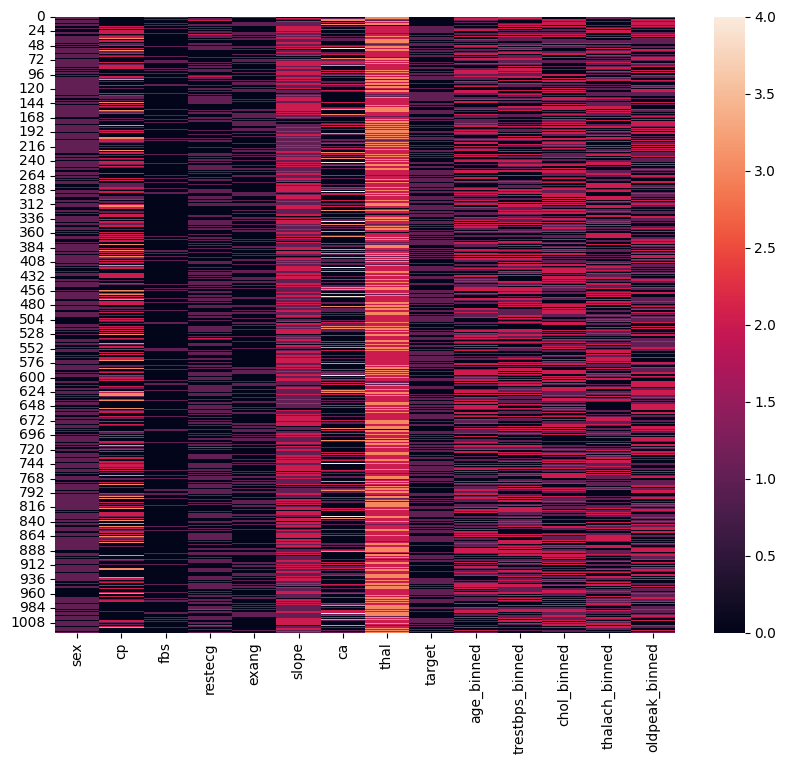

In [17]:
from sklearn.metrics import mutual_info_score
import seaborn as sns

# Initialize a DataFrame to store mutual information values
mi_matrix = pd.DataFrame(np.zeros((len(data.columns), len(data.columns))),
                         columns=data.columns, index=data.columns)

# Populate the mutual information matrix
for col1 in data.columns:
    for col2 in data.columns:
        if col1 != col2:
            mi = mutual_info_score(data[col1], data[col2])
            mi_matrix.loc[col1, col2] = mi

# Visualize the heatmap of mutual information
plt.figure(figsize=(10, 8))
sns.heatmap(data)


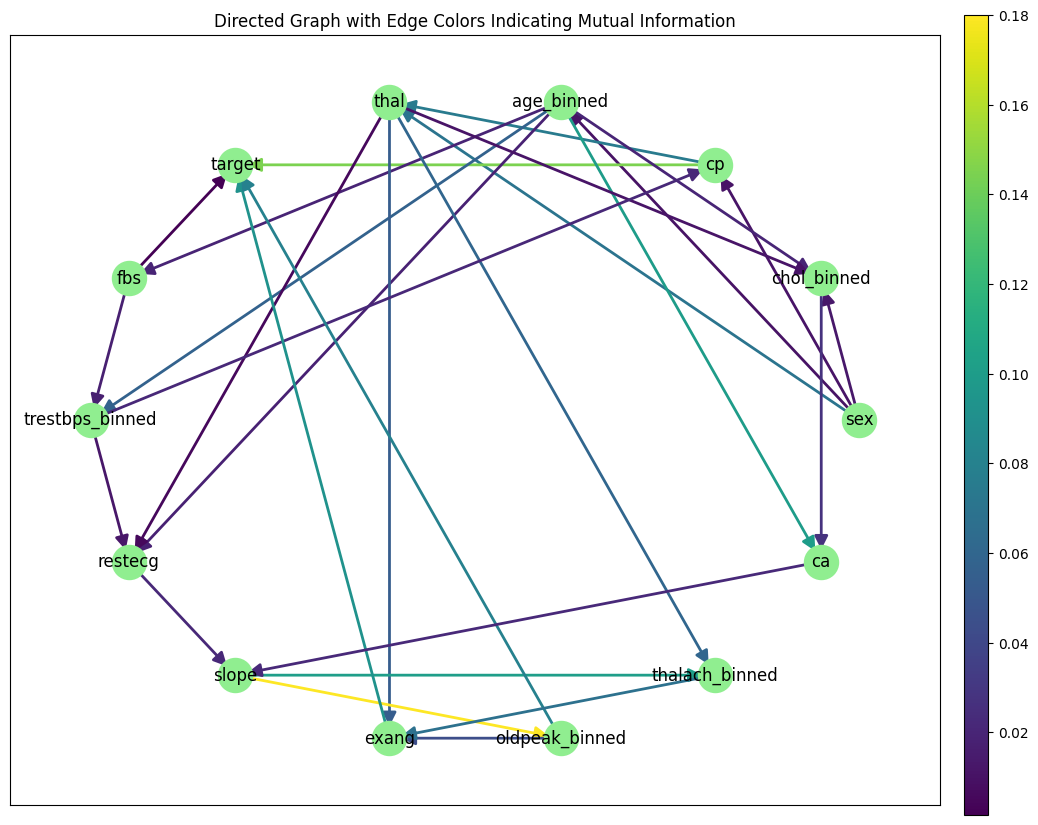

In [14]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from sklearn.metrics import mutual_info_score



# Initialize the mutual information matrix
mi_matrix = pd.DataFrame(np.zeros((len(train_data.columns), len(train_data.columns))),
                         columns=train_data.columns, index=train_data.columns)

# Populate the matrix with mutual information values
for col1 in train_data.columns:
    for col2 in train_data.columns:
        if col1 != col2:
            mi_matrix.loc[col1, col2] = mutual_info_score(train_data[col1], train_data[col2])

# Create a directed graph from the Bayesian Network structure
G = nx.DiGraph(bn_structure.edges())

# Normalize the mutual information values for color mapping
weights = [mi_matrix.loc[u, v] for u, v in G.edges()]
max_weight = max(weights)
min_weight = min(weights)
norm_weights = [(w - min_weight) / (max_weight - min_weight) for w in weights]

# Create a color map based on the normalized mutual information weights
cmap = plt.cm.viridis
edge_colors = [cmap(w) for w in norm_weights]

# Draw the network with edge colors based on the mutual information weights
fig, ax = plt.subplots(figsize=(12, 10))

# Use circular layout
pos = nx.circular_layout(G)  # This arranges the nodes in a circle

# Draw the network using the circular layout
nx.draw_networkx_nodes(G, pos, ax=ax, node_size=600, node_color='lightgreen')  # Slightly smaller nodes
nx.draw_networkx_labels(G, pos, ax=ax, font_size=12)
nx.draw_networkx_edges(G, pos, edgelist=G.edges(), ax=ax, edge_color=edge_colors, width=2, arrows=True, arrowsize=20)  # Larger arrowsx

#  create an axis for the colorbar
cax = fig.add_axes([0.92, 0.1, 0.02, 0.8])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_weight, vmax=max_weight))
sm.set_array([])
fig.colorbar(sm, cax=cax, orientation='vertical')
ax.set_title('Directed Graph with Edge Colors Indicating Mutual Information')

# Show the plot
plt.axis('on')
plt.show()
